# Model Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, \
                            accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
                             GradientBoostingClassifier, AdaBoostClassifier, \
                             VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [3]:
combined_df = pd.read_csv('./datasets/combined_df.csv')

In [92]:
sentiment_df = pd.read_csv('./datasets/sentiment_df.csv')

In [4]:
combined_df.shape

(1665, 18)

In the previous notebook, we cleaned the data that we scrapped from `r/MensLib` and `r/MensRights`. The next step that we'll cover below is selecting and tuning a model that can help predict where each post comes from. This is, in effect, a <b>binary classification problem</b>. To find the best model to use here, we'll carry out the following steps:

1. Run a Train-Test-Split on our data
2. Transform data using a vectorizer
3. Fit model to training data
4. Generate predictions using test data
5. Evaluate model based on various evaluation metrics (accuracy, precision, recall, ROC-AUC).
6. Select the best model and tune hyper-parameters

Besides CountVectorizer(), we'll also be using <b>TfidfVectorizer()</b>. TfidfVectorizer() is pretty similar to CountVectorizer, except that it looks at the frequency of words in our data. This means that it downweights words that appear in many posts, while upweighting the rarer words.

We'll look to test a range of classification techniques including Logistic Regression, Random Forest, Boosting, Multinomial Naive Bayes classification and Support Vector Machine (SVM) classification.

Accuracy and F-score will be our main metrics here, given that we're not too particularly concerned about minimizing either false negatives and false positives -- ideally we'd like to minimize both as far as possible.

## Baseline Model

To have something to compare our model against, we can use the normalized value of y, or the percentage of y within our target. This represents the simplest model we can use, where assigning a post randomly will give us a 53.4% chance of classifying it correctly.

In [5]:
# Baseline
y = combined_df['is_menslib']
y.value_counts(normalize=True)

1    0.534535
0    0.465465
Name: is_menslib, dtype: float64

## Train Test Split

In [6]:
X = combined_df['combi_text']
y = combined_df['is_menslib']

In [7]:
# Split our data into train and test data. We're stratifying here to ensure that the train and test sets 
# have approximately the same percentage of samples in order to avoid imbalanced classes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## Model Preparation

Here, I instantiated a range of different vectorizers and models. To simplify my workflow slightly, I opted to create a function that utilises Sklearn's Pipeline tool that allows for easy fitting and transformation of data.

In [8]:
# Instantiate vectorizers
vectorizers = {'cvec': CountVectorizer(),
               'tvec': TfidfVectorizer(),
               'hv': HashingVectorizer()}

In [9]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=1_000, random_state=42),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'nb': MultinomialNB(),
          'svc': SVC(random_state=42)}

In [10]:
# Function to run model -- input vectorizer and model
def run_model(vec, mod, vec_params={}, mod_params={}, grid_search=False):
    
    results = {}
    
    pipe = Pipeline([
            (vec, vectorizers[vec]),
            (mod, models[mod])
            ])
    
    if grid_search:
        gs = GridSearchCV(pipe, param_grid = {**vec_params, **mod_params}, cv=5, verbose=1, n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    results['model'] = mod
    results['vectorizer'] = vec
    results['train'] = pipe.score(X_train, y_train)
    results['test'] = pipe.score(X_test, y_test)
    predictions = pipe.predict(X_test)
    results['roc'] = roc_auc_score(y_test, predictions)
    results['specificity'] = precision_score(y_test, predictions)
    results['sensitivity'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        tuning_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        eval_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

## Model Testing

In [11]:
# Create list to store model testing results
eval_list = []

### Benchmark Model

As there were significant differences within the numerical features of the posts extracted from both subreddits (e.g. title/post length and number of comments), I wanted to test out a model with only these features. Surprisingly, this model performed pretty well and achieved a R2 score of 66.8% on the test data.

When including sentiment analysis information (compound score from VADER), this accuracy increases substantially to 71.2% on the test data. Clearly, sentiment is an important numerical feature for classifying our particular subreddit posts.

In [95]:
combined_df['title_len'] = len(combined_df['title'])
combined_df['selftext_len'] = len(combined_df['selftext'])
combined_df['compound'] = sentiment_df['compound']

In [122]:
# bm stands for benchmark
X_bm = combined_df[['upvotes', 'n_comments', 'title_len', 'selftext_len', 'compound']]
y_bm = combined_df['is_menslib']

In [123]:
# Split our data into train and test data
X_bm_train, X_bm_test, y_train, y_test = train_test_split(X_bm, y_bm, test_size=0.3, stratify=y, random_state=42)

In [124]:
logreg = LogisticRegression()
logreg.fit(X_bm_train, y_train)

LogisticRegression()

In [125]:
logreg.score(X_bm_train, y_train)

0.7184549356223175

In [126]:
logreg.score(X_bm_test, y_test)

0.712

In [127]:
bm1_pred = logreg.predict(X_bm_test)

In [128]:
tn, fp, fn, tp = confusion_matrix(y_test, bm1_pred).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 161
False Positives: 72
False Negatives: 72
True Positives: 195


Here, <b>True Negatives</b> are `r/MensRights` posts that were correctly classified by our model. <b>True Positives</b> are `r/MensLib` posts that were correctly classified by our model. 

With sentiment scores excluded,  our model did particularly badly in predicting `r/MensRights` posts, with 116 posts from `r/MensLib` classified as `r/MensRights` posts. With sentiment scores included, the overall f-score increased from 0.67 to 0.71.

In [129]:
print(classification_report(y_test, bm1_pred))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       233
           1       0.73      0.73      0.73       267

    accuracy                           0.71       500
   macro avg       0.71      0.71      0.71       500
weighted avg       0.71      0.71      0.71       500



### Logistic Regression

In [21]:
# Logistic Regression with CountVectorizer
cvec_lr = run_model('cvec', 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'train': 0.9982832618025751,
 'test': 0.8,
 'roc': 0.8001639581424507,
 'specificity': 0.8223938223938224,
 'sensitivity': 0.797752808988764,
 'f_score': 0.8098859315589354}

True Negatives: 187
False Positives: 46
False Negatives: 54
True Positives: 213


In [22]:
# Logistic Regression with TfdifVectorizer
tvec_lr = run_model('tvec', 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'train': 0.9339055793991416,
 'test': 0.794,
 'roc': 0.791266817765347,
 'specificity': 0.7928571428571428,
 'sensitivity': 0.8314606741573034,
 'f_score': 0.8117001828153565}

True Negatives: 175
False Positives: 58
False Negatives: 45
True Positives: 222


Out of curiosity, I also tried out scikit learn's <b>HashingVectorizer()</b>, which was designed to be as memory efficient as possible. Instead of storing the tokens as strings, the vectorizer applies a hashing trick to encode tokens as numerical indexes. The downside of this method is that once vectorized, our features’ names can no longer be retrieved.

Due to this and weaker scores compared to the other two vectorizers, I decided against this method in evaluating my other models. 

In [23]:
# Logistic Regression with HashingVectorizer
hv_lr = run_model('hv', 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'hv',
 'train': 0.8463519313304722,
 'test': 0.77,
 'roc': 0.7668820626577293,
 'specificity': 0.7695035460992907,
 'sensitivity': 0.8127340823970037,
 'f_score': 0.7905282331511839}

True Negatives: 168
False Positives: 65
False Negatives: 50
True Positives: 217


### Random Forest / Extra Tree Classifier with CVEC

The random forest algorithm works very differently from logistic regression -- random forest is a tree-based machine learning algorithm that leverages the power of multiple decision trees for making decisions. As the name suggests, this model involves a 'forest' of trees, with each tree randomly created. Each node in the decision tree works on a random subset of features to calculate the output, and then combines the output of individual decision trees to generate the final output.

The Extra Trees classifier works similar to this, but incorporates bootstrap aggregation (or random sampling with replacement) in order to reduce variance and help with overfitting. In general, both methods provided worse results relative to logistic regression.

In [24]:
cvec_rf = run_model('cvec', 'rf')

### METRICS ###


{'model': 'rf',
 'vectorizer': 'cvec',
 'train': 1.0,
 'test': 0.768,
 'roc': 0.7658291941939528,
 'specificity': 0.7745454545454545,
 'sensitivity': 0.797752808988764,
 'f_score': 0.7859778597785978}

True Negatives: 171
False Positives: 62
False Negatives: 54
True Positives: 213


In [25]:
tvec_rf = run_model('tvec', 'rf')

### METRICS ###


{'model': 'rf',
 'vectorizer': 'tvec',
 'train': 1.0,
 'test': 0.774,
 'roc': 0.7706273810097893,
 'specificity': 0.7711267605633803,
 'sensitivity': 0.8202247191011236,
 'f_score': 0.7949183303085299}

True Negatives: 168
False Positives: 65
False Negatives: 48
True Positives: 219


In [26]:
cvec_et = run_model('cvec', 'et')

### METRICS ###


{'model': 'et',
 'vectorizer': 'cvec',
 'train': 1.0,
 'test': 0.754,
 'roc': 0.7494414171127293,
 'specificity': 0.7465753424657534,
 'sensitivity': 0.8164794007490637,
 'f_score': 0.7799642218246869}

True Negatives: 159
False Positives: 74
False Negatives: 49
True Positives: 218


In [27]:
tvec_et = run_model('tvec', 'et')

### METRICS ###


{'model': 'et',
 'vectorizer': 'tvec',
 'train': 1.0,
 'test': 0.782,
 'roc': 0.7783912812846603,
 'specificity': 0.7762237762237763,
 'sensitivity': 0.8314606741573034,
 'f_score': 0.8028933092224232}

True Negatives: 169
False Positives: 64
False Negatives: 45
True Positives: 222


### Adaptive Boost & Gradient Boost

Both of these methods are ensemble machine learning methods that combine multiple simple models into a single composite model. Both adaptive and gradient boosting involves building weak learners in a sequential fashion, with the final prediction generated by the weighted average of all the weak learners, where more weight is placed on stronger learners. Adaptive boosting is slightly different from gradient boosting, as it put more weight on misclassified samples and less weight on correctly classified samples.

In [28]:
cvec_ada = run_model('cvec', 'ada')

### METRICS ###


{'model': 'ada',
 'vectorizer': 'cvec',
 'train': 0.7828326180257511,
 'test': 0.748,
 'roc': 0.7531144009901787,
 'specificity': 0.8190045248868778,
 'sensitivity': 0.6779026217228464,
 'f_score': 0.7418032786885247}

True Negatives: 193
False Positives: 40
False Negatives: 86
True Positives: 181


In [29]:
tvec_ada = run_model('tvec', 'ada')

### METRICS ###


{'model': 'ada',
 'vectorizer': 'tvec',
 'train': 0.8412017167381974,
 'test': 0.752,
 'roc': 0.7552201379177316,
 'specificity': 0.8042553191489362,
 'sensitivity': 0.7078651685393258,
 'f_score': 0.7529880478087649}

True Negatives: 187
False Positives: 46
False Negatives: 78
True Positives: 189


In [30]:
cvec_gb = run_model('cvec', 'gb')

### METRICS ###


{'model': 'gb',
 'vectorizer': 'cvec',
 'train': 0.8566523605150215,
 'test': 0.798,
 'roc': 0.7993843532494254,
 'specificity': 0.832,
 'sensitivity': 0.7790262172284644,
 'f_score': 0.804642166344294}

True Negatives: 191
False Positives: 42
False Negatives: 59
True Positives: 208


In [31]:
tvec_gb = run_model('tvec', 'gb')

### METRICS ###


{'model': 'gb',
 'vectorizer': 'tvec',
 'train': 0.9175965665236051,
 'test': 0.812,
 'roc': 0.8103068589156258,
 'specificity': 0.8168498168498168,
 'sensitivity': 0.8352059925093633,
 'f_score': 0.825925925925926}

True Negatives: 183
False Positives: 50
False Negatives: 44
True Positives: 223


Our graident boosting model in this case is outperforming our adaptive boosting model with a markedly higher accuracy on both train and test data.

### Naive Bayes

A Naive Bayes classifier is a probabilistic machine learning model that's commonly used in classification problems. The crux of the classifier is based on the Bayes theorem, where our target variable is represented as a probability function based on our text features. 

To put it another way, Naive Bayes classifiers works off Bayes' theroem, which describes the probability of an event, based on prior knowledge of conditions that might be related to the event.

We'll be using a Multinomial Naive Bayes that looks at the frequency of the words present in our data.

In [32]:
cvec_nb = run_model('cvec', 'nb')

### METRICS ###


{'model': 'nb',
 'vectorizer': 'cvec',
 'train': 0.9278969957081545,
 'test': 0.792,
 'roc': 0.7861149957403031,
 'specificity': 0.768976897689769,
 'sensitivity': 0.8726591760299626,
 'f_score': 0.8175438596491228}

True Negatives: 163
False Positives: 70
False Negatives: 34
True Positives: 233


In [33]:
tvec_nb = run_model('tvec', 'nb')

### METRICS ###


{'model': 'nb',
 'vectorizer': 'tvec',
 'train': 0.8051502145922746,
 'test': 0.68,
 'roc': 0.6580186783687771,
 'specificity': 0.6282973621103117,
 'sensitivity': 0.9812734082397003,
 'f_score': 0.7660818713450293}

True Negatives: 78
False Positives: 155
False Negatives: 5
True Positives: 262


Our Multinomial Naive Bayes classifier has an extremely high sensitivity and is great at predicting `r/MensRights` posts, but conversely does badly in predicting `r/MensLib` posts.

### Support Vector Machine Classifier

The principle behind the support vector machine classifer is simple -- the algorithm simply separates data points using a hyperplane with the largest amount of margin and classifies them accordingly. In other words, the algorithm determines the best decision boundary between vectors that belong to a given group (or category) and vectors that do not belong to it. 

In [34]:
cvec_svc = run_model('cvec', 'svc')

### METRICS ###


{'model': 'svc',
 'vectorizer': 'cvec',
 'train': 0.7356223175965665,
 'test': 0.686,
 'roc': 0.697248075099259,
 'specificity': 0.8160919540229885,
 'sensitivity': 0.5318352059925093,
 'f_score': 0.6439909297052154}

True Negatives: 201
False Positives: 32
False Negatives: 125
True Positives: 142


In [35]:
tvec_svc = run_model('tvec', 'svc')

### METRICS ###


{'model': 'svc',
 'vectorizer': 'tvec',
 'train': 0.9974248927038627,
 'test': 0.814,
 'roc': 0.8113597273794024,
 'specificity': 0.8107142857142857,
 'sensitivity': 0.850187265917603,
 'f_score': 0.829981718464351}

True Negatives: 180
False Positives: 53
False Negatives: 40
True Positives: 227


In [36]:
eval_df = pd.DataFrame(eval_list)

In [37]:
# Top results (Accuracy >= 0.790)
eval_df.sort_values(by='test', ascending=False).reset_index(drop=True).head(6)

,model,vectorizer,train,test,roc,specificity,sensitivity,f_score
0,svc,tvec,0.997425,0.814,0.811360,0.810714,0.850187,0.829982
1,gb,tvec,0.917597,0.812,0.810307,0.816850,0.835206,0.825926
2,lr,cvec,0.998283,0.800,0.800164,0.822394,0.797753,0.809886
3,gb,cvec,0.856652,0.798,0.799384,0.832000,0.779026,0.804642
4,lr,tvec,0.933906,0.794,0.791267,0.792857,0.831461,0.811700
5,nb,cvec,0.927897,0.792,0.786115,0.768977,0.872659,0.817544


As our Random Forest models don't have coefficients, we'll go with the models that returned the best results across the board -- we can see that both our logistic regression and gradient models did particularly well, with our support vector machine classifier topping the list in terms of both accuracy and AUC-ROC score.

## Model Tuning

In [38]:
# Instantiate list to store tuning results
tuning_list = []

#### Vectorizer Parameters

In [39]:
cvec_params = {
    # Setting a limit of n-number of features included/vocab size
    'cvec__max_features': [None, 12_000],

    # Setting a minimum number of times the word/token has to appear in n-documents
    'cvec__min_df':[2, 3, 4],
    
    # Setting an upper threshold/max percentage of n% of documents from corpus 
    'cvec__max_df': [0.2, 0.3, 0.4],
    
    # With stopwords
    'cvec__stop_words': ['english'],
    
    # Testing with bigrams and trigrams
    'cvec__ngram_range':[(1,1), (1,2)],
}

In [40]:
tvec_params = {
    'tvec__max_features': [None],
    'tvec__min_df':[3, 4, 5],
    'tvec__max_df': [0.2, 0.3, 0.4],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range':[(1,1), (1,2)]
}

#### Model Parameters

In [41]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1'],

     # Trying different alphas of: 10, 1, 0.1 (C = 1/alpha)
    'lr__C':[0.1, 1, 10],
}

In [42]:
nb_params = {
    'nb__fit_prior': [True, False],
    'nb__alpha': [0, 0.4, 0.8]
}

In [43]:
svc_params = {
    'svc__C':[0.1, 1, 10],
    'svc__gamma':[0.01, 0.1, 0.3], 
    'svc__kernel':['linear','rbf'],
}

There are a few parameters here that need a bit of explanation:

- Alpha represents the level of regularization that we want to apply to our model -- in the case of our naive bayes model, this affects the level of LaPlace smoothing which helps to reduce the impact of zero probabilities in the case where none of the words in the training sample appear in the test sentence. 


- C is a penalty parameter, which represents misclassification or error term. The misclassification or error term tells the model how much error is bearable, which allows us to control the trade-off between decision boundary and misclassification term. When C is high it will classify all the data points correctly, but lead to a high risk of overfitting. Conversely, when C is low, it will 'smooth' out the decision boundary and could potentially lead to underfitting.


- Gamma is a parameter that influences the calculation of plausible line of separation for SVM. When gamma is higher, nearby points will have high influence in the calculation of the decision boundary. Conversely, a low gamma means far away points also be considered when calculating the decision boundary.

### Hyperparameter Tuning

#### Logistic Regression with CVEC

In [44]:
# Always stop_words & never trigrams (best_results without model tuning)
cvec_lr_gs = run_model('cvec', 'lr', vec_params=cvec_params, mod_params=lr_params, grid_search=True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   28.2s finished


### BEST PARAMS ###


{'cvec__max_df': 0.3,
 'cvec__max_features': None,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'lr__C': 1,
 'lr__penalty': 'l2'}

### METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'train': 0.9879828326180258,
 'test': 0.824,
 'roc': 0.8234556589670637,
 'specificity': 0.8377358490566038,
 'sensitivity': 0.8314606741573034,
 'f_score': 0.8345864661654135}

True Negatives: 190
False Positives: 43
False Negatives: 45
True Positives: 222


#### Logistic Regression with TVEC

In [45]:
tvec_lr_gs = run_model('tvec', 'lr', vec_params=tvec_params, mod_params=lr_params, grid_search=True)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 517 out of 540 | elapsed:   10.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   10.4s finished


### BEST PARAMS ###


{'lr__C': 10,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.2,
 'tvec__max_features': None,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

### METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'train': 0.9931330472103004,
 'test': 0.834,
 'roc': 0.830086319139702,
 'specificity': 0.8172413793103448,
 'sensitivity': 0.8876404494382022,
 'f_score': 0.8509874326750448}

True Negatives: 180
False Positives: 53
False Negatives: 30
True Positives: 237


#### Multinomial Naive Bayes with CVEC

In [46]:
cvec_nb_gs = run_model('cvec', 'nb', vec_params=cvec_params, mod_params=nb_params, grid_search=True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   25.6s finished


### BEST PARAMS ###


{'cvec__max_df': 0.2,
 'cvec__max_features': None,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'nb__alpha': 0.8,
 'nb__fit_prior': False}

### METRICS ###


{'model': 'nb',
 'vectorizer': 'cvec',
 'train': 0.8935622317596567,
 'test': 0.824,
 'roc': 0.8242754496793172,
 'specificity': 0.8455598455598455,
 'sensitivity': 0.8202247191011236,
 'f_score': 0.8326996197718631}

True Negatives: 193
False Positives: 40
False Negatives: 48
True Positives: 219


#### Support Machine Classifier with TVEC

In [47]:
tvec_svc_gs = run_model('tvec', 'svc', vec_params=tvec_params, mod_params=svc_params, grid_search=True)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.1min finished


### BEST PARAMS ###


{'svc__C': 1,
 'svc__gamma': 0.01,
 'svc__kernel': 'linear',
 'tvec__max_df': 0.3,
 'tvec__max_features': None,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

### METRICS ###


{'model': 'svc',
 'vectorizer': 'tvec',
 'train': 0.9725321888412017,
 'test': 0.826,
 'roc': 0.8215026281525775,
 'specificity': 0.8061224489795918,
 'sensitivity': 0.8876404494382022,
 'f_score': 0.8449197860962567}

True Negatives: 176
False Positives: 57
False Negatives: 30
True Positives: 237


## Final Model Selection

In [48]:
tuning_df = pd.DataFrame(tuning_list)

In [49]:
tuning_df.sort_values(by=['test', 'roc'], ascending=False).reset_index(drop=True)

,model,vectorizer,train,test,roc,specificity,sensitivity,f_score
0,lr,tvec,0.993133,0.834,0.830086,0.817241,0.887640,0.850987
1,svc,tvec,0.972532,0.826,0.821503,0.806122,0.887640,0.844920
2,nb,cvec,0.893562,0.824,0.824275,0.845560,0.820225,0.832700
3,lr,cvec,0.987983,0.824,0.823456,0.837736,0.831461,0.834586


We can see in the table above that logistic regression with TfidfVectorizer returned the highest R2 accuracy -- in short, our model is able accurately predict 83.4% of the test data based on our text features. The model also has the best AUC-ROC score. We can interpret this metric as proof that that this model is the best at distinguishing between classes. The model does particularly very well in terms of sensitivity, with only 30 false negatives (predicted `r/MensRights` but actually `r/MensLib` posts).

While the Multinomial Naive Bayes model with CountVectorizer is better at minimizing false positives (predicted `r/MensLib` but actually `r/MensRights` posts), the Logistic Regression model with TfidfVectorizer still wins overall in terms of test accuracy and f-score.

To summarize, our final model:
<i>
- uses Tfidf Vectorization with no max feature limit <br>
- includes only words or n-grams that appear in at least 4 posts <br>
- excludes stop words and ignores terms that that appear in more than 20% of posts <br>
- uses Logistic Regression with Ridge regluarization ($\alpha$ = 0.1 | C = 10)
</i>

Our model is still overfitting quite a bit as indicated by the large gap between training and test scores, but this seems to be the limit to which we can push our model.

#### AUC-ROC Curve

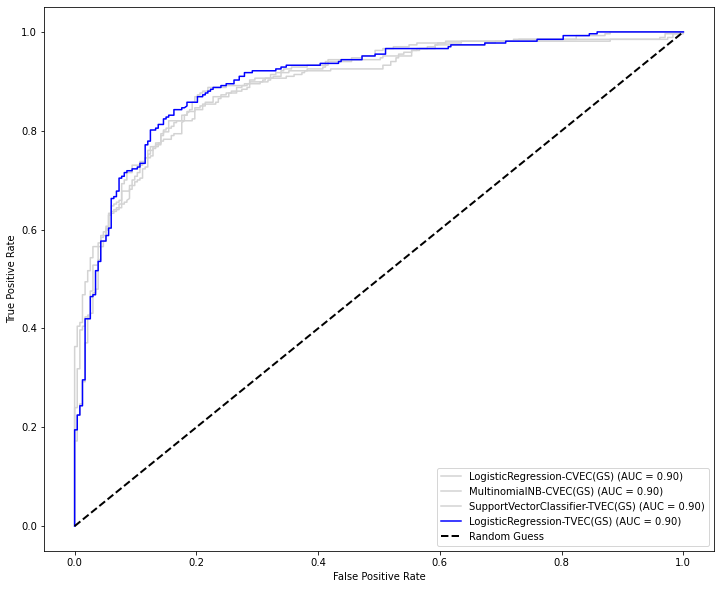

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plot_roc_curve(cvec_lr_gs, X_test, y_test, ax=ax, name='LogisticRegression-CVEC(GS)', color='lightgrey')
plot_roc_curve(cvec_nb_gs, X_test, y_test, ax=ax, name='MultinomialNB-CVEC(GS)', color='lightgrey')
plot_roc_curve(tvec_svc_gs, X_test, y_test, ax=ax, name='SupportVectorClassifier-TVEC(GS)', color='lightgrey')
plot_roc_curve(tvec_lr_gs, X_test, y_test, ax=ax, name='LogisticRegression-TVEC(GS)', color='blue')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
plt.legend()

We  can see that our chosen model, Logistic Regression with TfidfVectorizer does pretty well as indicated by the AUC-ROC curve. The other classifiers all come pretty close, but it's clear that our chosen model is generally outperforming the other models at most decision thresholds, apart from the start of the curve.

# Model Insights

Each post has a probability assigned to it that determines whether our model classifies it as a `r/MensLib` or `r/MensRights` post. What we can do here, is to look at these probabilities and identify the top posts that model believes to be indicative of a particular subreddit.

In [51]:
tvec_lr_gs.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.2, min_df=4, ngram_range=(1, 2),
                                 stop_words='english')),
                ('lr',
                 LogisticRegression(C=10, max_iter=1000, random_state=42))])

In [52]:
coefs = pd.DataFrame(tvec_lr_gs.best_estimator_.steps[1][1].coef_).T
coefs.columns = ['coef']
coefs['ngram'] = tvec_lr_gs.best_estimator_.steps[0][1].get_feature_names()
coefs = coefs[['ngram','coef']]
coefs = coefs.sort_values('coef', ascending=True)

In [53]:
top_mensrights_coefs = coefs.head(15).reset_index(drop=True)
top_menslib_coefs = coefs.tail(15).sort_values(by='coef', ascending=False).reset_index(drop=True)

By looking at the coefficients from our model, we can determine the words or n-grams that are most related to r/MensLib and r/MensRights. As we assigned r/MensRights posts to 0, and r/MensLib posts to 1, words or n-grams with the lowest negative coefficients are words or n-grams that are most predictive of r/MensRight. This applies vice versa for r/MensLib. What our model has done here, is to search for words and n-grams that appear frequently in one subreddit relative to the other.

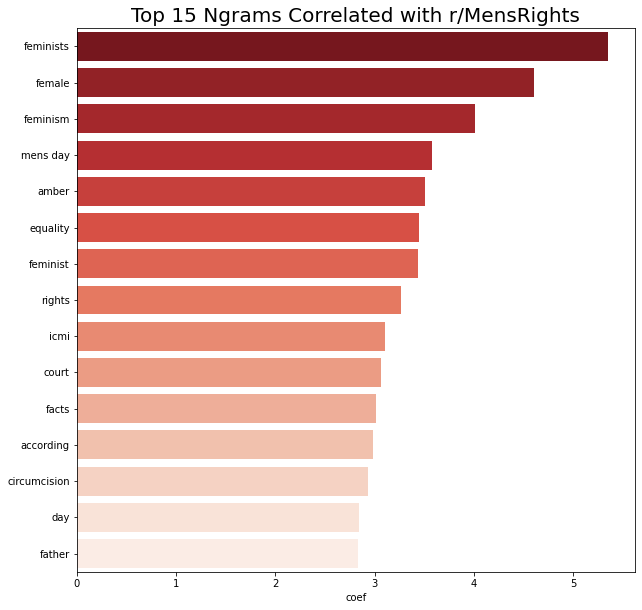

In [91]:
plt.figure(figsize=(10,10))
sns.barplot(data=top_mensrights_coefs, x=-top_mensrights_coefs['coef'], y='ngram', palette='Reds_r')
plt.ylabel('')
plt.title('Top 15 Ngrams Correlated with r/MensRights', fontsize=20);

There are extremely strong correlations around the terms feminists, feminism, female and feminist. This makes sense, given that the men's rights movement largely believes that [feminism harms men by concealing discrimination and promoting gynocentrism](https://books.google.com.sg/books?id=jh7y6ELc90YC&redir_esc=y). The top few words from the sub are therefore focused around the loss of rights, and a push towards 'equality'. For `r/MensRights`, the case of Johnny Depp and Amber Heard represents a percieved 'imbalance of power' between sexes, and serves to reinforce their belief that men are victims.

We also see other areas where `r/MensRights` belives that men are disadvantaged -- in terms of court cases and the issue of male circumcision. The [International Conference on Men's Issues](https://www.washingtonpost.com/lifestyle/style/mens-rights-activists-gathering-to-discuss-all-the-ways-society-has-done-them-wrong/2014/06/30/a9310d96-005f-11e4-8fd0-3a663dfa68ac_story.html) is also a point of interest here. It represents men coming together to take on the so-called 'specter' of feminism.

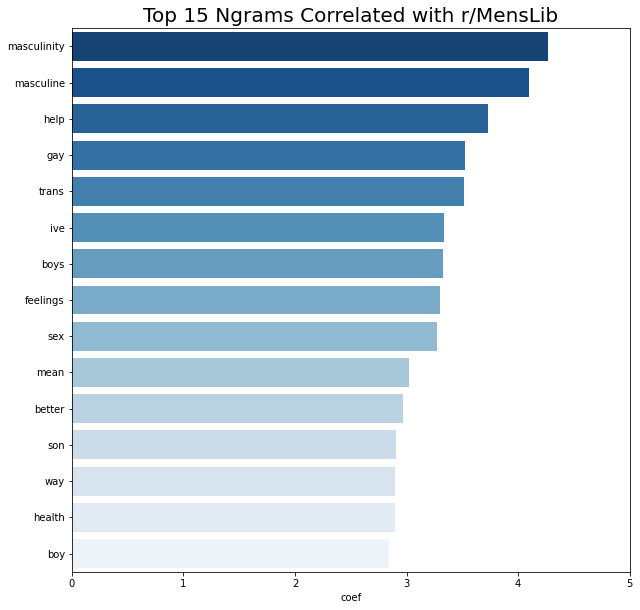

In [89]:
plt.figure(figsize=(10,10))
sns.barplot(data=top_menslib_coefs, x=top_menslib_coefs['coef'], y='ngram', palette='Blues_r')
plt.xticks(np.arange(0, 6, step=1))
plt.ylabel('')
plt.title('Top 15 Ngrams Correlated with r/MensLib', fontsize=20);

`r/MensLib` is much more focused around masculinity as compared to feminism. We see that mentions of feminism aren't central here, which makes sense given that `r/MensLib` is a pro-feminism sub that focuses on how masculinity, particularly toxic masculinity can harm both men and women. The spectrum that these words cover seems to quite broad, covering boys and men, including trans and gay men.

We can also see that relative to `r/MensRights`,`r/MensLib` is much more focused around inter-personal relationships and personal issues.

#### Predictive Wordclouds

In [56]:
from wordcloud import WordCloud

In [57]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 14))
    plt.imshow(wordcloud)
    plt.axis("off");

In [58]:
menslib_posts = list(combined_df[combined_df['is_menslib'] == 1]['combi_text'])

In [59]:
mensrights_posts = list(combined_df[combined_df['is_menslib'] == 0]['combi_text'])

Text(0.5, 1.0, 'r/MensLib')

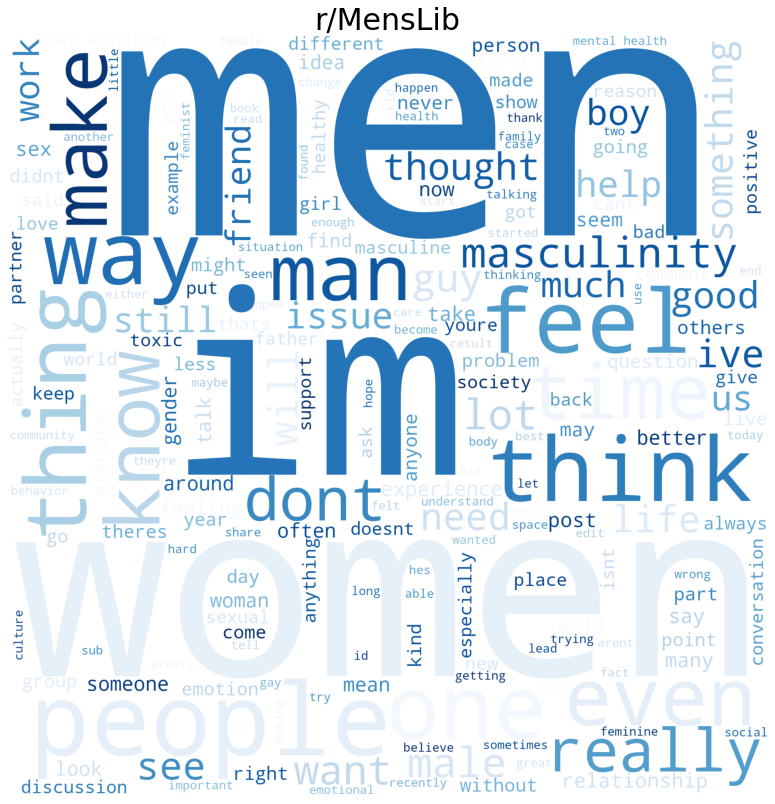

In [60]:
menslib_wordcloud = WordCloud(
            width = 2000, height = 2000, random_state = 42,
            background_color = 'white',colormap='Blues',
            max_font_size = 900).generate(' '.join(menslib_posts))

plot_cloud(menslib_wordcloud)
plt.title('r/MensLib', fontsize=30)

Text(0.5, 1.0, 'r/MensRights')

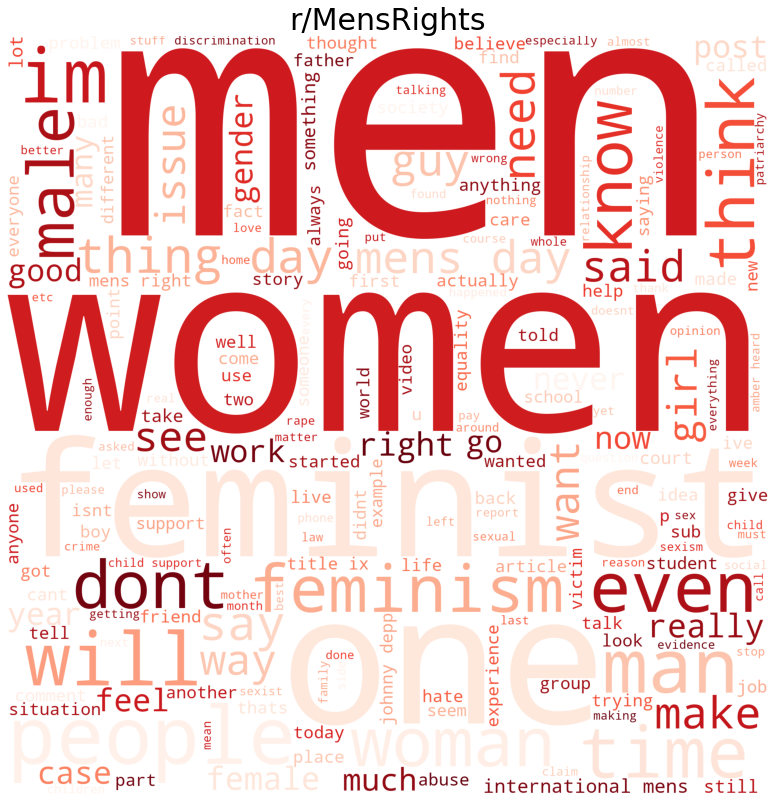

In [61]:
mensrights_wordcloud = WordCloud(
            width = 2000, height = 2000, random_state = 42,
            background_color = 'white',colormap='Reds',
            max_font_size = 900).generate(' '.join(mensrights_posts))

plot_cloud(mensrights_wordcloud)
plt.title('r/MensRights', fontsize=30)

In [62]:
predictions = pd.DataFrame(tvec_lr_gs.predict_proba(X))
predictions['combi_text'] = combined_df['combi_text']

In [63]:
predictions.columns = ['mensrights', 'menslib', 'combi_text']

#### Top Predicted Posts

In [64]:
# Top predicted r/mensrights posts
predictions.sort_values('mensrights', ascending=False)[:15]

,mensrights,menslib,combi_text
1208,0.998705,0.001295,sjw feminists are stealing international mens ...
1233,0.997787,0.002213,feminist hypocrisy and international mens day ...
1578,0.997508,0.002492,petition justice for johnny depp against domes...
1126,0.997295,0.002705,how amber heards abuse and accusations destroy...
1022,0.996742,0.003258,johnny depp is being blackmailed by amber heard
1608,0.996470,0.003530,petition to remove amber heard after she admit...
1485,0.995503,0.004497,complete silence on amber heards admission of ...
1537,0.994381,0.005619,johnny depp good amber heard bad
1185,0.994271,0.005729,the un celebrates international mens day by ma...
1545,0.994238,0.005762,johnny depp loses to amber heard where is the ...


We can see that our model has a pretty good grasp on typical `r/MensRights` posts here. Posts that include mention of Johnny Depp or Amber Heard are strongly predicted as `r/MensRights` posts, along with anything mentioning feminism or international men's day.

In [65]:
# Top predicted r/menslib posts
predictions.sort_values('menslib', ascending=False)[:15]

,mensrights,menslib,combi_text
642,0.000818,0.999182,im a trans man who struggles with being mascul...
113,0.000975,0.999025,i feel like theres two different pressures act...
866,0.001494,0.998506,on sex between trans and cis men questions po...
57,0.001683,0.998317,what my life as a trans woman has taught me ab...
256,0.002108,0.997892,toward positive masculinity there have been a ...
207,0.002198,0.997802,dating somebody new is showing me how rare it ...
510,0.002201,0.997799,men should not be shamed for liking feminine a...
50,0.003339,0.996661,sex negativity is not the answer to male liber...
552,0.003468,0.996532,a reflection during international mens health ...
68,0.003636,0.996364,to lgbtq men andor men who feel different beca...


We see that strongly predicted `r/MensLib` posts are posts that involve mention of the LGBTQ community -- this suggests that discussion of men/LGBTQ issues are largely absent from `r/MensRights`. We can probably assume that that subreddit doesn't have a particularly intersectional community.

In [66]:
def print_post(string, post):
    try:
        if string.lower() in post.lower():
            print(post)
            print('-----')
    except AttributeError:
        pass

In [67]:
predictions = pd.DataFrame(tvec_lr_gs.predict_proba(X))
predictions['combined_text'] = combined_df['combi_text']
predictions['pred'] = cvec_lr_gs.predict(X)
predictions['actual'] = combined_df['is_menslib']

In [68]:
# Reorder columns
predictions.columns = ['mensrights','menslib','combined_text','pred', 'actual']
predictions = predictions[['combined_text', 'pred','actual','mensrights','menslib']]

In [69]:
wrong_predictions = predictions[predictions['actual']!=predictions['pred']]

In [70]:
# False positives -- posts that model wrongly classified as r/menslib
wrong_predictions[(wrong_predictions['menslib'] > 0.85) & (wrong_predictions['pred'] == 1)]

,combined_text,pred,actual,mensrights,menslib
1130,creative men support group i have a weekly men...,1,0,0.133108,0.866892
1131,my year old dad opened up for the first time ...,1,0,0.091817,0.908183
1308,could hour shifts improve mens mental health ...,1,0,0.072995,0.927005
1482,what were men not allowed to do years ago for...,1,0,0.063357,0.936643
1527,must watch solid masculine life game masculini...,1,0,0.052861,0.947139
1550,do russian people support same sex marriage w...,1,0,0.132117,0.867883


In [71]:
for i in combined_df['og_text']:
    print_post('hour shifts', i)

Could 6 hour shifts improve men's mental health ?

[https://youtu.be/0abk5crGk2c](https://youtu.be/0abk5crGk2c)

Simple : Finland and Sweden are slowly moving towards a 6 hour shift workday while maintaining the 8 hour pay. Do you think this could help men's mental health ? Keep in mind companies see an increase in productivity and they could hire 30% more workers for the extra shift and employees are less stressed ! Don't believe me ... the company's owner own words ! [https://brath.com/why-we-started-with-6-hour-work-days/](https://brath.com/why-we-started-with-6-hour-work-days/)
-----


In [72]:
for i in combined_df['og_text']:
    print_post('old dad opened', i)

My 54 year old dad opened up for the first time in his life.

I am currently a college student, and I moved back home because of covid shutting down campus about 1.5 months ago. My dad has never been the type of person to discuss emotions, and we have always had a strained relationship because we dont quite understand each other's struggles. A few days ago, I went to the kitchen to get some water and saw he was awake watching TV at midnight. I swallowed my pride and asked "dad, how are you holding up."

I won't get into detail, but it is the first time in about 6 years that I have hugged my father, and we have developed a better understanding of each other. He had a lot to talk about, and I urge every man to ask their fathers (in an isolated environment) about their feelings. There is so much to be learned, and so much to be fixed.
-----


In [73]:
# False negatives -- posts that model wrongly classified as r/mensrights
wrong_predictions[wrong_predictions['mensrights'] > 0.85]

,combined_text,pred,actual,mensrights,menslib
144,the equal rights amendment i just watched a vi...,0,1,0.940003,0.059997
328,refutations of the alleged benefits of infant ...,0,1,0.915383,0.084617
393,the trial of johnny depp and amber heard hi al...,0,1,0.943406,0.056594
572,supreme court says federal law protects lgbtq ...,0,1,0.918251,0.081749
672,how concerning are the trump administrations n...,0,1,0.895248,0.104752
803,should men discuss feminism paul morrin,0,1,0.854151,0.145849


In [74]:
for i in combined_df['og_text']:
    print_post('the trial of johnny depp', i)

The Trial of Johnny Depp and Amber Heard

Hi all, first off, I wanted to say I love this group. Everyone here seems so level headed, engaging and takes time to read posts carefully. What a fabulous lot.

I have been thinking about the current domestic abuse trial between Amber Heard and Johnny Depp.
It is awful, hearing what allegedly happened between them, it is so toxic.

However, I have been wondering, I personally think this could be a large step in the right direction for male victims of domestic abuse. There is still a huge stigma attached to men who suffer from domestic violence, so as a result, so many stay silent. Its horrible that these poor men can speak out of fear of not being believed.

I have been thinking that perhaps seeing a man who is seen as so strong and the 'ideal man' can suffer from such atrocities, maybe more men will come forward about their abuse? 'If it can happen to Johnny Depp, it could happen to me.'

What do you think? I'd love to hear people's views.
I 

#### Model Limitations

As demonstrated by the false predictions above, our model does have some limitations, especially when it comes to predicting `r/MensRights` posts. Mentioning mental health throws off our model, even though it could potentially be an issue pertinent to `r/MensRights`. When it comes to the wire, both groups care deeply about similar issues facing men (e.g. male suicide, male parenting, male gential cutting), even if their approach and beliefs are fundamentally different. Similarly, mentions of Amber Heard and Johnny Depp are disproprtionately weighted and can easily throw the model off.

I also wouldn't be surprised if `r/MensLib` is sometimes critical of certain branches of feminism or feminists that espouse hate towards men as as an entire group.

In today's day and age, gender issues continue to be extremely complicated, and even a well trained model will still struggle to differentiate men and their beliefs that exist across a wide spectrum.

To further improve model accuracy, we'd ideally need to train our model to recognize slightly more abstract concepts such as the level of introspection or sentiment within the post. This would allow our model to deal with issues that are topical to  `r/MensRights` (e.g. Johnny Depp and Amber Heard), but classify posts not just by mention of a name, but also by syntactic patterns that suggest introspection such as like 'I have been thinking' or 'I'd love to hear people's views'.